In [1]:
import numpy as np
import matplotlib.pyplot as plt
import evofr as ef

# Simulating fake data

In [2]:
# Need to simulate predictors for multiple generations
# Generation sizes and distances
np.random.seed(90)

# True coefficients
beta = np.array([2.8, 1.0, -1.5, -0.4])
pop_sizes = np.array([100, 101, 99, 98, 101])
mu = 3.0

def sim_step(init_freq, beta, mu, S_now, S_next):
    # Sample predictor values and define fitness
    predictors = np.random.normal(size=(S_now, beta.shape[0])) 
    predictors = predictors
    fitness = np.dot(predictors, beta)
    
    # Project population by fitness
    proj_freq = init_freq * np.exp(fitness)
    proj_freq = proj_freq / proj_freq.sum()
    
    # Sample new population and distances
    # Basically sample ancestors using proj_freq as probability
    ancestors = np.random.choice(a=S_now, size=S_next, p=proj_freq)
    distances = np.zeros((S_now, S_next))
    
    # Add random noise to non-ancestor pairs
    distances += np.random.randint(20, 40, size=(S_now, S_next))
    ancestor_descendent = (ancestors, np.arange(S_next))
    
    # Add Poisson noise expected from neutral evolution
    distances[ancestor_descendent] = np.random.poisson(mu, size=S_next)

    # Sample initial frequencies f
    next_init_freq = np.zeros(S_next)
    for ancestor in np.unique(ancestors):
        is_ancestor = (ancestor == ancestors)
        num_desc = is_ancestor.sum() # Number with this ancestor
        frac_desc = num_desc / S_next # Fraction descended from this ancestor
        
        # Break descendents into groups of size expected from projected population
        descend_freq = np.random.dirichlet([1] * num_desc) * frac_desc
        next_init_freq[is_ancestor] += descend_freq
    next_init_freq = next_init_freq / next_init_freq.sum()
    
    return predictors, distances, proj_freq, ancestors, next_init_freq

    
def simulate_distances(beta, pop_sizes, mu):
    # Start from a single generation
    init_freq = np.random.dirichlet([4.0] * pop_sizes[0])    

    G = len(pop_sizes)
    init_freqs = []
    predictors = []
    distances = []
    proj_freqs = []
    ancestors = []
    
    for g in range(G-1):
        # Get shapes for time step
        S_now, S_next = pop_sizes[g], pop_sizes[g+1]
        
        # Simulate predictors, distances, and next generation frequencies
        predictor, distance, proj_freq, ancestor, next_init_freq = sim_step(init_freq, beta, mu, S_now, S_next)
    
        # Save into lists
        init_freqs.append(init_freq)
        predictors.append(predictor)
        distances.append(distance)
        proj_freqs.append(proj_freq)
        ancestors.append(ancestor)
        
        # Update initial frequency for next step
        init_freq = next_init_freq
    
    # Getting values for the last generation
    # Get initial frequencies and predictors for last generation
    init_freqs.append(init_freq)
    
    predictor = np.random.normal(size=(pop_sizes[-1], beta.shape[0]))
    predictor = predictor
    predictors.append(predictor)

    fitness = np.dot(predictor, beta)
    
    # Project population by fitness
    proj_freq = init_freq * np.exp(fitness)
    proj_freq = proj_freq / proj_freq.sum()
     
    proj_freqs.append(proj_freq)

    return init_freqs, predictors, distances, proj_freqs, ancestors

In [3]:
init_freqs, predictors, distances, proj_freqs, ancestors = simulate_distances(beta, pop_sizes, mu)

In [4]:
init_freqs[0].shape, predictors[0].shape, distances[0].shape

((100,), (100, 4), (100, 101))

In [5]:
def ancestor_from_dist(distances):
    T = len(distances)
    ancestor_dist = []
    for t in range(T):
        ancestor_dist.append(
            np.argmin(distances[t], axis=0)
        )
    return ancestor_dist
ancestor_dist = ancestor_from_dist(distances)

In [6]:
def counts_from_init_freqs(init_freqs, N):
    T = len(init_freqs)
    counts = []
    for t in range(T):
        counts.append(
            np.random.multinomial(N, init_freqs[t])
        )
    return counts
counts = counts_from_init_freqs(init_freqs, 4000)

# Running the model

In [7]:
# Base model without counts or ancestors
data = ef.models.StrainDistanceData(
    init_freq=init_freqs, 
    predictors=predictors, 
    distances=distances)

In [8]:
# Model including counts and fixed ancestors
data = ef.models.StrainDistanceData(
    init_freq=None,
    counts=counts, 
    predictors=predictors, 
    distances=distances, 
    ancestors=ancestor_dist)

In [9]:
model = ef.models.StrainDistanceModel()

In [10]:
# Fitting model
#inference_method = ef.InferFullRank(iters=50_000, lr=4e-4, num_samples=1000)

inference_method = ef.InferNUTS(num_warmup=5000, num_samples=1000)
#inference_method = ef.InferMAP(iters=100_000, lr=4e-4)
posterior = inference_method.fit(model, data)

sample: 100%|██████████████████████████████████████████| 6000/6000 [00:06<00:00, 979.56it/s, 15 steps of size 2.67e-01. acc. prob=0.88]


In [11]:
#fig = plt.figure(figsize=(14, 10))
#gs = fig.add_gridspec(nrows=2, ncols=1)
#ax = fig.add_subplot(gs[0,0])
#ax.plot(posterior.samples["losses"])
#ax.set_yscale("log", base=10)

In [12]:
posterior.samples.keys()

dict_keys(['coefficients', 'fitness_0', 'fitness_1', 'fitness_2', 'fitness_3', 'init_freq_0', 'init_freq_1', 'init_freq_2', 'init_freq_3', 'init_freq_4', 'mu', 'proj_freq_0', 'proj_freq_1', 'proj_freq_2', 'proj_freq_3', 'ancestor_counts_0', 'ancestor_counts_1', 'ancestor_counts_2', 'ancestor_counts_3', 'ancestor_distances_0', 'ancestor_distances_1', 'ancestor_distances_2', 'ancestor_distances_3', 'fitness_4', 'proj_freq_4'])

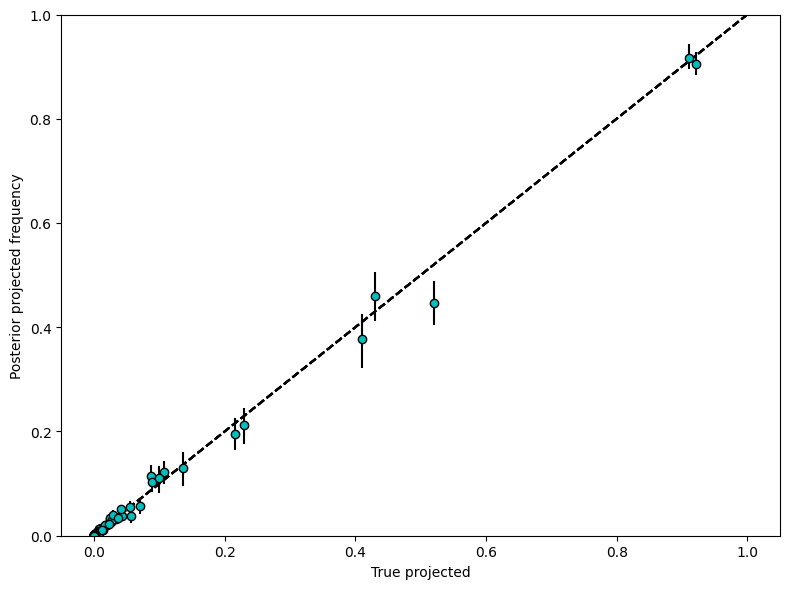

In [13]:
fig = plt.figure(figsize=(8, 6))
    
T = len(distances) + 1
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

for t in range(T):

    S = len(init_freqs[t])
    
    med, quants = ef.get_quantiles(posterior.samples, [0.8], f"proj_freq_{t}")
    ax.plot([0.0, 1.0], [0.0, 1.0], color = 'k', linestyle = "--")
    
    yerr = [quants[0][1,:] - med,   med - quants[0][0,:]]
    ax.errorbar(proj_freqs[t], med, yerr=yerr, fmt="o", markeredgecolor="k", color="c", ecolor="k", label="Truth")
    # Axis labels
    ax.set_xlabel("True projected")
    ax.set_ylabel("Posterior projected frequency")
    ax.set_ylim(0.0, 1.0)
    
fig.tight_layout()

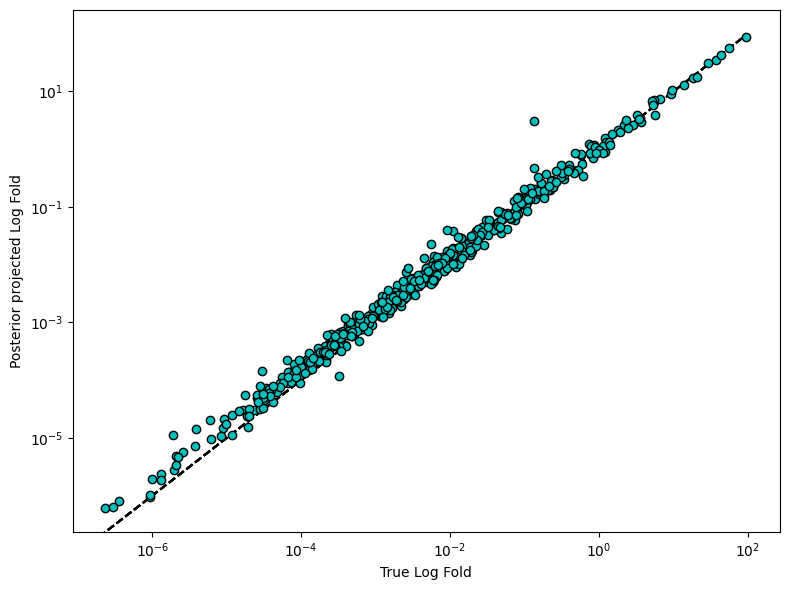

In [14]:
fig = plt.figure(figsize=(8, 6))
    
T = len(distances) + 1
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

for t in range(T):

    S = len(init_freqs[t])
    
    med, quants = ef.get_quantiles(posterior.samples, [0.8], f"proj_freq_{t}")
    ax.plot([0.0, 100.0], [0.0, 100.0], color = 'k', linestyle = "--")
    
    yerr = [(quants[0][1,:] - med),   (med - quants[0][0,:])]
    
    ax.errorbar(proj_freqs[t] / init_freqs[t], med / init_freqs[t], yerr=yerr, fmt="o", markeredgecolor="k", color="c", ecolor="k", label="Truth")
    
    # Axis labels
    ax.set_xlabel("True Log Fold")
    ax.set_ylabel("Posterior projected Log Fold")
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)

fig.tight_layout()

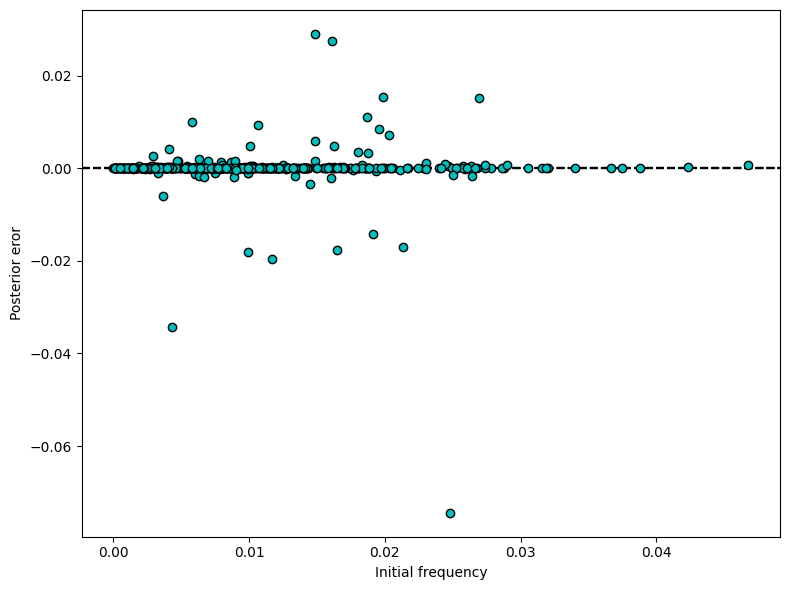

In [15]:
fig = plt.figure(figsize=(8, 6))
    
T = len(distances) + 1
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

for t in range(T):
    S = len(init_freqs[t])
    
    med, quants = ef.get_quantiles(posterior.samples, [0.8], f"proj_freq_{t}")
    med = med - proj_freqs[t]    
    ax.errorbar(init_freqs[t], med, fmt="o", markeredgecolor="k", color="c", ecolor="k", label="Truth")
    ax.axhline(y=0.0, color="k", linestyle="--")
    # Axis labels
    ax.set_xlabel("Initial frequency")
    ax.set_ylabel("Posterior eror")
    
fig.tight_layout()

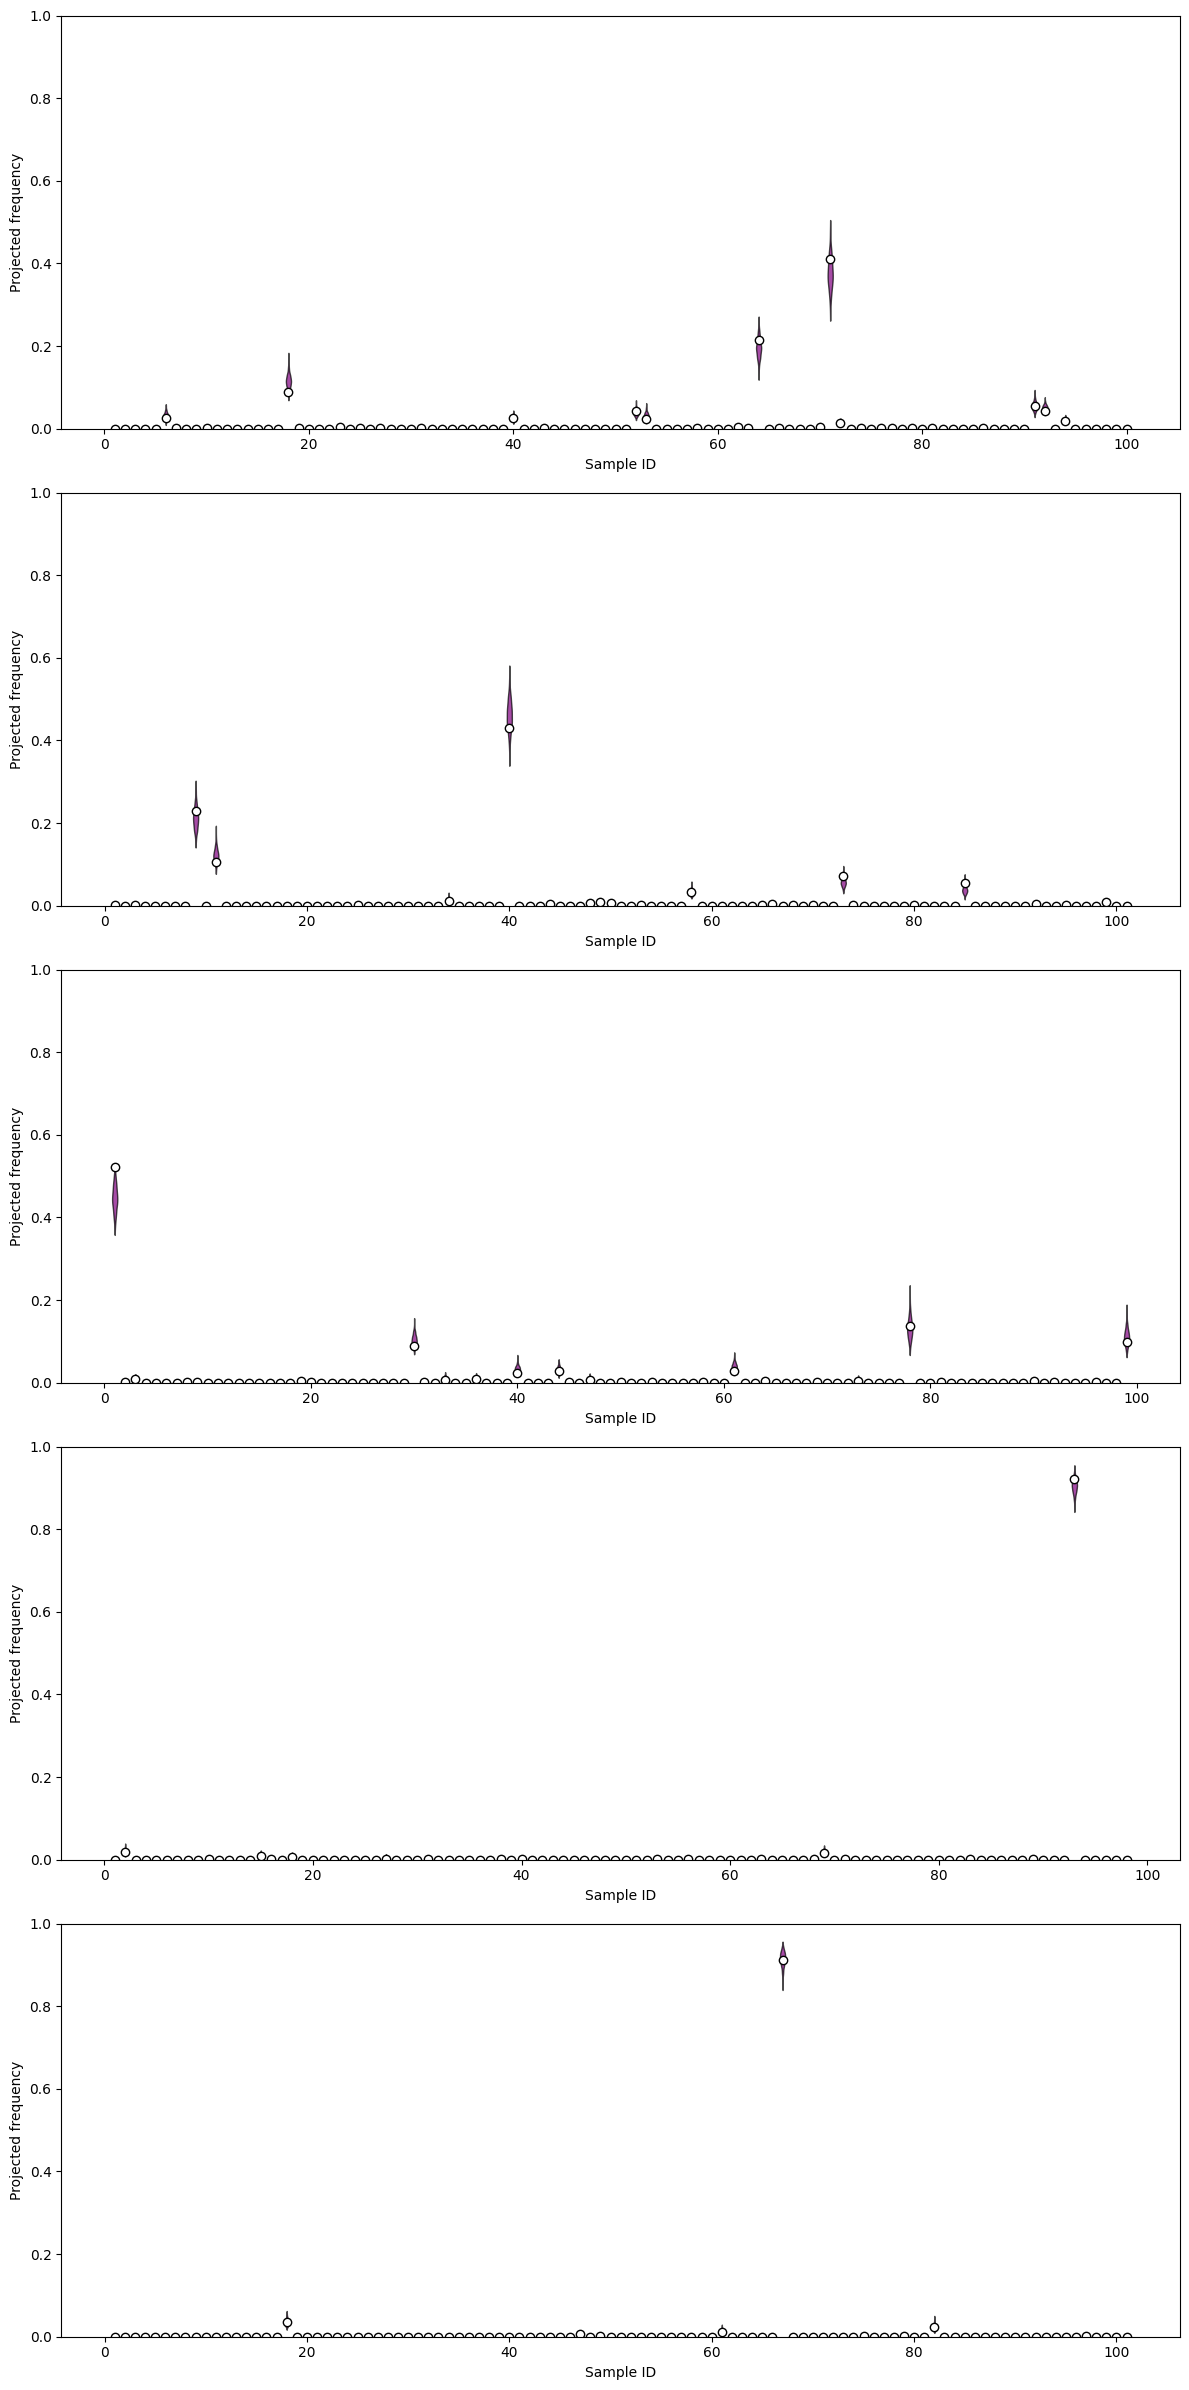

In [16]:
fig = plt.figure(figsize=(12, 24))
    
T = len(distances) + 1
gs = fig.add_gridspec(nrows=T, ncols=1)

for t in range(T):
    ax = fig.add_subplot(gs[t,0])

    S = len(init_freqs[t])
    
    proj_freq_samples = [posterior.samples[f"proj_freq_{t}"][:,i] for i in range(S)]

    # Violin plot
    parts = ax.violinplot(proj_freq_samples,
                 showmeans=False, 
                showmedians=False,
                  showextrema=False) 
    
    for pc in parts['bodies']:
        pc.set_facecolor('purple')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    inds = np.arange(1, S + 1)
    
    # Scatter plot of truth
    ax.scatter(inds, proj_freqs[t], color="w", ec='k', label="Truth")
    
    # Axis labels
    ax.set_xlabel("Sample ID")
    ax.set_ylabel("Projected frequency")
    ax.set_ylim(0.0, 1.0)
    
fig.tight_layout()

Text(0.5, 0, 'Mutation rate')

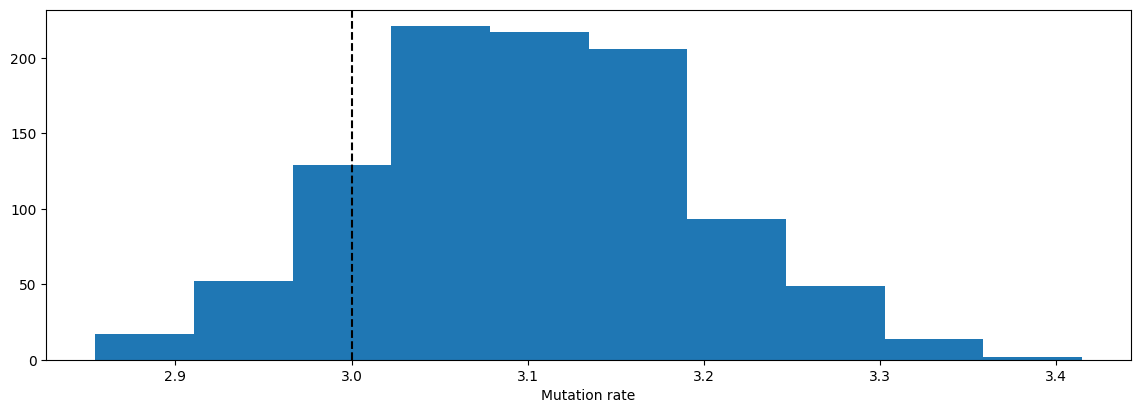

In [17]:
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0,0])
if "mu" in posterior.samples.keys():
    ax.hist(posterior.samples["mu"])
ax.axvline(x=mu, color="k", linestyle="--")
ax.set_xlabel("Mutation rate")



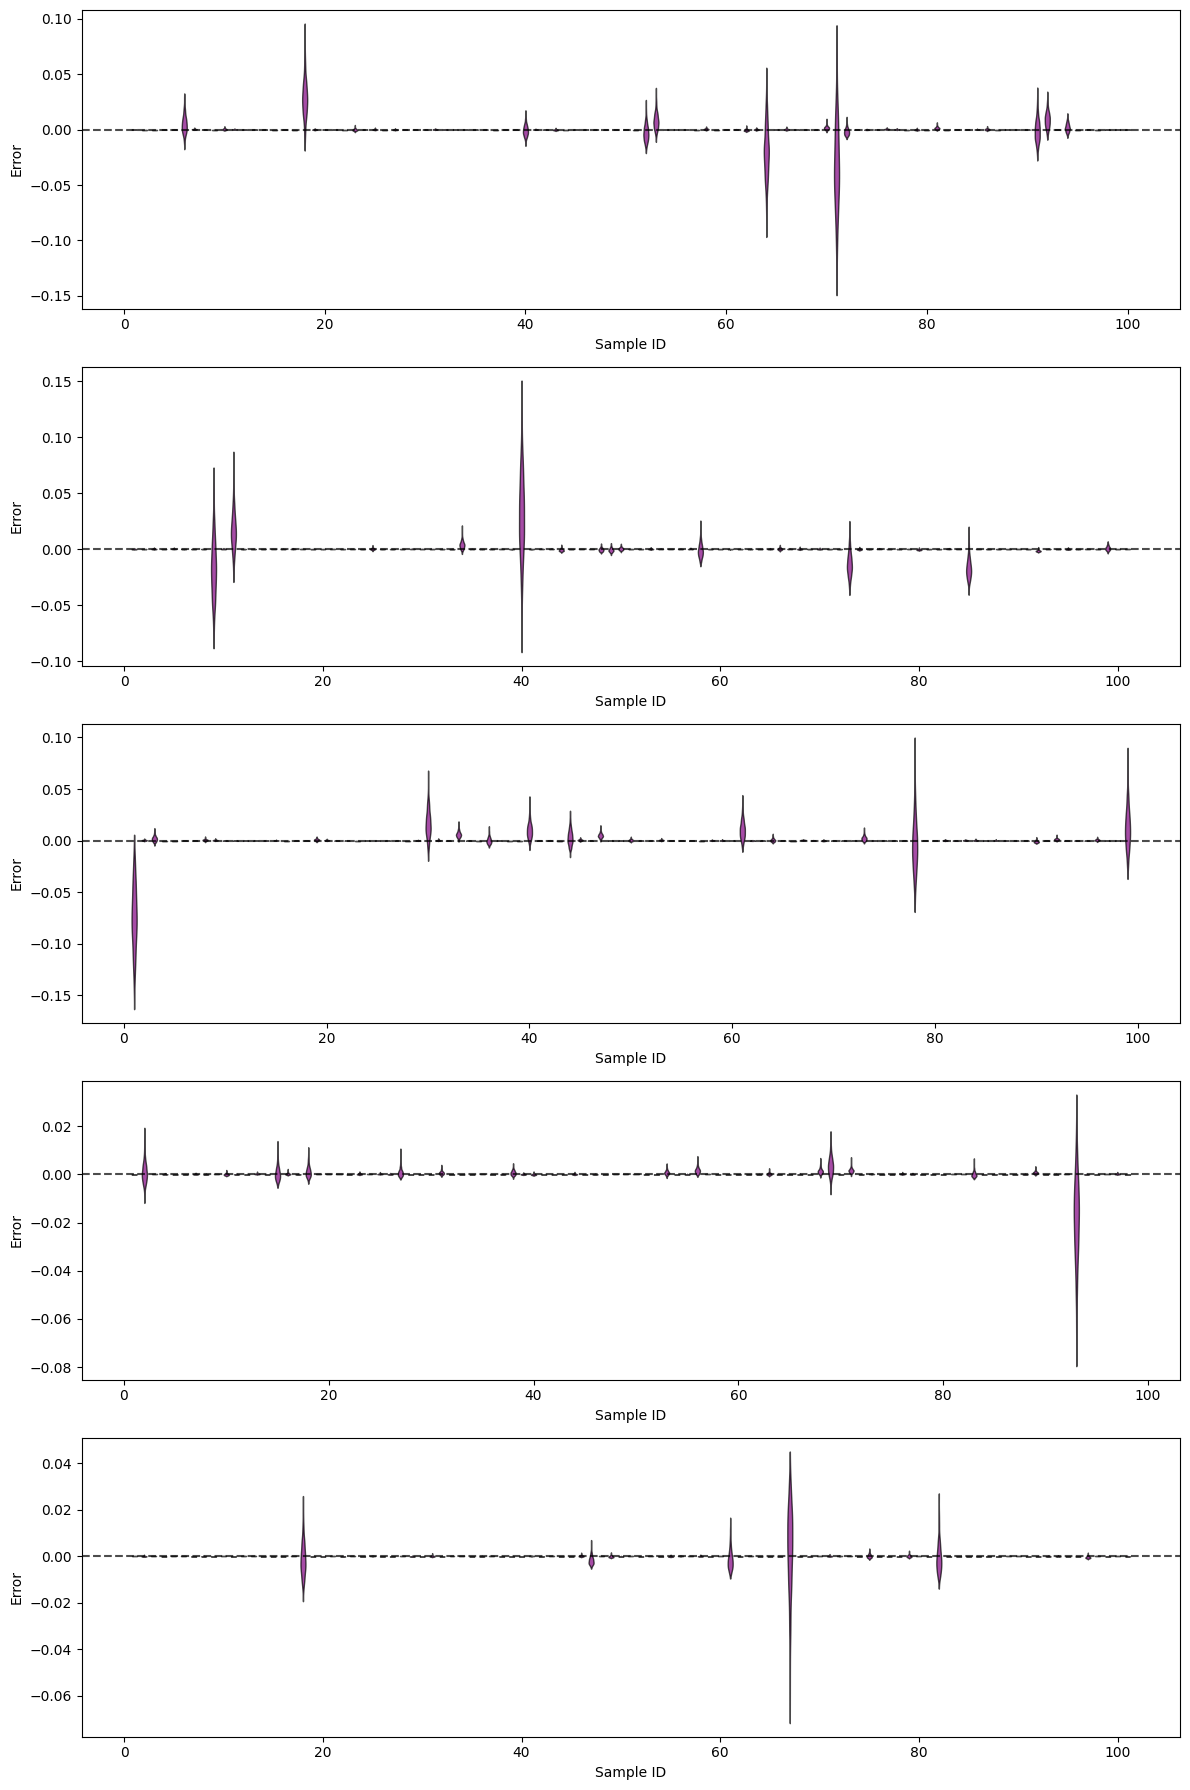

In [18]:
fig = plt.figure(figsize=(12, 18))
    
T = len(distances) + 1
gs = fig.add_gridspec(nrows=T, ncols=1)

for t in range(T):
    ax = fig.add_subplot(gs[t,0])

    S = len(init_freqs[t])
    
    proj_freq_samples = [posterior.samples[f"proj_freq_{t}"][:,i] - proj_freqs[t][i] for i in range(S)]

    # Violin plot
    parts = ax.violinplot(proj_freq_samples,
                 showmeans=False, 
                showmedians=False,
                  showextrema=False) 
    
    for pc in parts['bodies']:
        pc.set_facecolor('purple')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        
    ax.axhline(y=0.0, color="k", linestyle="--", alpha=0.7)
        
    # Axis labels
    ax.set_xlabel("Sample ID")
    ax.set_ylabel("Error")
fig.tight_layout()

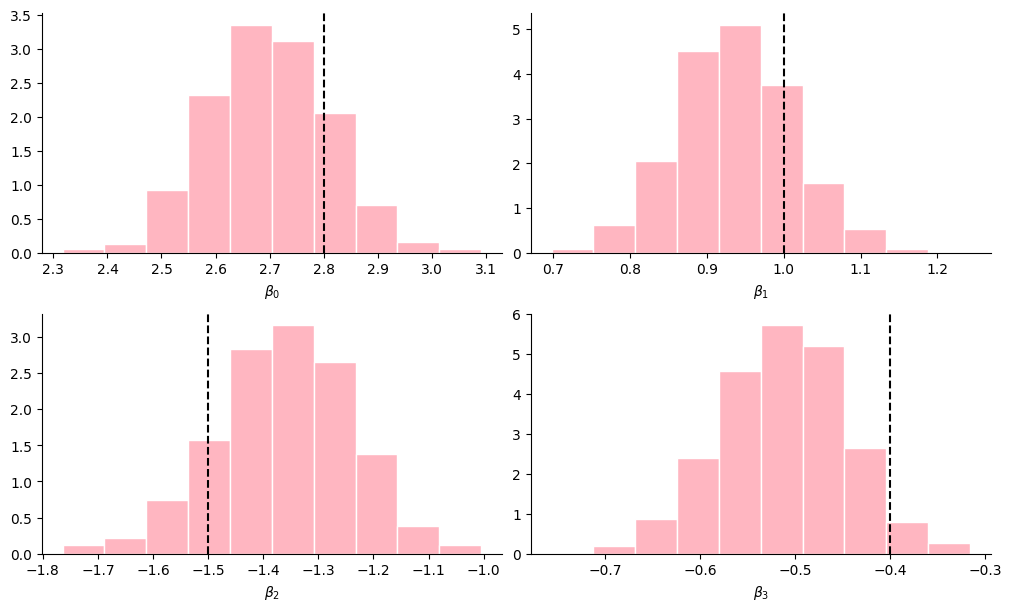

In [19]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)


for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.hist(posterior.samples["coefficients"][:, i], ec="w", color="#FFB6C1", density=True)
    ax.axvline(x=beta[i], color="k", linestyle="--")
    ax.set_xlabel(rf"$\beta_{i}$")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)